In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
enrollment_data = pd.read_csv("..\\Data\\normalized_enrollment\\normalized_enrollment.csv", low_memory=False)
biometric_data = pd.read_csv("..\\Data\\normalized_biometric1\\normalized_biometric1.csv", low_memory=False)
demographic_data = pd.read_csv("..\\Data\\normalized_demographic\\normalized_demographic.csv", low_memory=False)

# Convert date
for df in [enrollment_data, biometric_data, demographic_data]:
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Age-Wise Aadhaar Lifecycle Drop-offs

## Aligning Time Windows

In [4]:
start_date = max(
    enrollment_data['date'].min(),
    biometric_data['date'].min(),
    demographic_data['date'].min()
)

end_date = min(
    enrollment_data['date'].max(),
    biometric_data['date'].max(),
    demographic_data['date'].max()
)

enrollment_f = enrollment_data[(enrollment_data['date'] >= start_date) & (enrollment_data['date'] <= end_date)]
biometric_f = biometric_data[(biometric_data['date'] >= start_date) & (biometric_data['date'] <= end_date)]
demographic_f = demographic_data[(demographic_data['date'] >= start_date) & (demographic_data['date'] <= end_date)]


## Aggregate (State + District)

In [6]:
enroll_agg = enrollment_f.groupby(['state', 'district'], as_index=False).sum(numeric_only=True)

In [8]:
bio_agg = biometric_f.groupby(['state', 'district'], as_index=False).sum(numeric_only=True)

In [10]:
demo_agg = demographic_f.groupby(['state', 'district'], as_index=False).sum(numeric_only=True)

In [11]:
df = enroll_agg.merge(bio_agg, on=['state', 'district'], how='left')
df = df.merge(demo_agg, on=['state', 'district'], how='left')

df = df.fillna(0)

## Q1: Are children enrolled early but missing biometric updates later?

In [12]:
df['child_to_bio_gap'] = df['age_5_17'] - df['bio_age_5_17']

## Q2: Are young adults updating demographics without biometric refresh?

In [13]:
df['demo_without_bio_gap'] = df['demo_age_17_'] - df['bio_age_17_']

## Q3: Do regions fail at child → adult transition?

In [14]:
df['child_to_adult_gap'] = df['age_5_17'] - df['age_18_greater']

In [15]:
def q1_insight(x):
    if x > 10000:
        return "Severe biometric drop-off risk"
    elif x > 2000:
        return "Moderate biometric drop-off"
    elif x >= 0:
        return "Healthy lifecycle"
    else:
        return "Backlog clearing / catch-up activity"

df['q1_insight'] = df['child_to_bio_gap'].apply(q1_insight)


## State-wise + District-wise Views

In [16]:
state_view = df.groupby('state', as_index=False).sum()

In [17]:
df.sort_values(['state', 'child_to_bio_gap'], ascending=[True, False])

,state,district,pincode_x,age_0_5,age_5_17,age_18_greater,pincode_y,bio_age_5_17,bio_age_17_,pincode,demo_age_5_17,demo_age_17_,child_to_bio_gap,demo_without_bio_gap,child_to_adult_gap,q1_insight
0,andaman and nicobar islands,nicobar,29027753,65,11,0,1.481161e+08,815.0,719.0,0.0,0.0,0.0,-804.0,-719.0,11,Backlog clearing / catch-up activity
1,andaman and nicobar islands,north middle andaman,119810864,193,9,0,5.484464e+08,3637.0,3735.0,0.0,0.0,0.0,-3628.0,-3735.0,9,Backlog clearing / catch-up activity
2,andaman and nicobar islands,south andaman,136175213,210,11,0,6.615340e+08,5742.0,3347.0,0.0,0.0,0.0,-5731.0,-3347.0,11,Backlog clearing / catch-up activity
4,andhra pradesh,anakapalli,231004289,513,12,8,7.747773e+08,3324.0,2947.0,0.0,0.0,0.0,-3312.0,-2947.0,4,Backlog clearing / catch-up activity
7,andhra pradesh,bapatla,212212327,414,52,16,8.520803e+08,3785.0,1952.0,0.0,0.0,0.0,-3733.0,-1952.0,36,Backlog clearing / catch-up activity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,west bengal,paschim medinipur,3701362031,16055,4346,170,6.086351e+09,67619.0,84766.0,0.0,0.0,0.0,-63273.0,-84766.0,4176,Backlog clearing / catch-up activity
761,west bengal,purba bardhaman,5786191775,16472,3619,141,1.176330e+10,77982.0,108247.0,0.0,0.0,0.0,-74363.0,-108247.0,3478,Backlog clearing / catch-up activity
756,west bengal,murshidabad,3331977291,31063,4184,85,4.849398e+09,81629.0,114662.0,0.0,0.0,0.0,-77445.0,-114662.0,4099,Backlog clearing / catch-up activity
758,west bengal,north 24 parganas,5428780807,25656,8312,1844,9.617877e+09,89730.0,122282.0,0.0,0.0,0.0,-81418.0,-122282.0,6468,Backlog clearing / catch-up activity


In [20]:
df.to_csv("..\\Data\\aadhar_insights.csv", index=False)

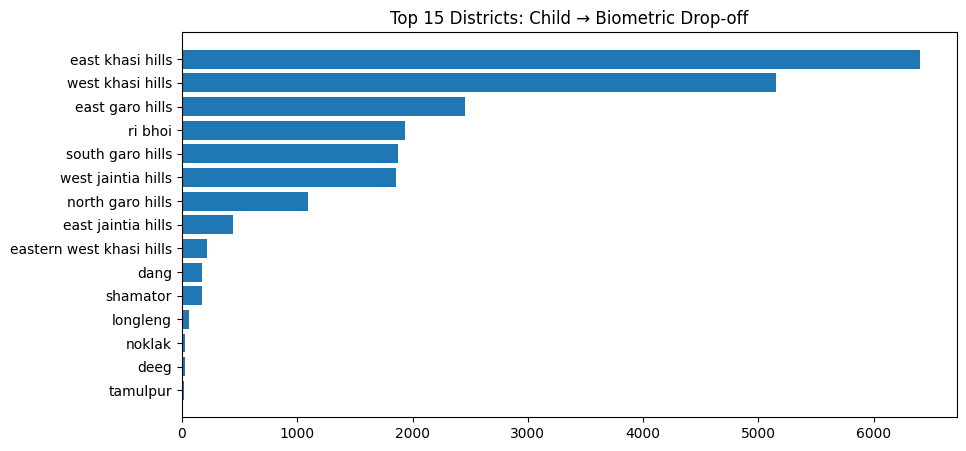

In [18]:
import matplotlib.pyplot as plt

top = df.sort_values('child_to_bio_gap', ascending=False).head(15)

plt.figure(figsize=(10,5))
plt.barh(top['district'], top['child_to_bio_gap'])
plt.title("Top 15 Districts: Child → Biometric Drop-off")
plt.gca().invert_yaxis()
plt.show()


## Insights: Child → Biometric Drop-off

The biometric drop-off is mainly concentrated in a few districts, not spread across the country.

Most high drop-off districts are in Meghalaya, especially East Khasi Hills and West Khasi Hills.

These districts show that children are enrolled, but many have not completed biometric updates.

The issue appears to be regional, affecting hill and North-Eastern districts more than others.

This is not an enrollment problem, but a follow-up and access problem after enrollment.

Possible reasons include difficult terrain, fewer biometric centers, and limited physical access.

Well-connected and urban districts show much lower or no drop-off, highlighting the role of infrastructure.

# Migration & Urban Pressure Signals

## Defining the Migration Pressure Index

### Interpreting the Index
MPI Value	Interpretation

< 1	Stable population

1 – 3	Mild migration

3 – 6	High migration

greater than 6 Severe urban / migrant pressure

In [21]:
df['migration_pressure_index'] = (
    df['bio_age_17_'] + df['demo_age_17_']
) / (df['age_18_greater'] + 1)

## Classify Districts Automatically

In [22]:
def classify_migration(x):
    if x > 6:
        return "Severe urban pressure (migration hub)"
    elif x > 3:
        return "High migration activity"
    elif x > 1:
        return "Moderate migration"
    else:
        return "Stable / low migration"

df['migration_signal'] = df['migration_pressure_index'].apply(classify_migration)


## Identify Top Migration / Urban Pressure Zones

In [23]:
top_migration_districts = df.sort_values(
    'migration_pressure_index',
    ascending=False
).head(15)[
    ['state', 'district', 'migration_pressure_index', 'migration_signal']
]


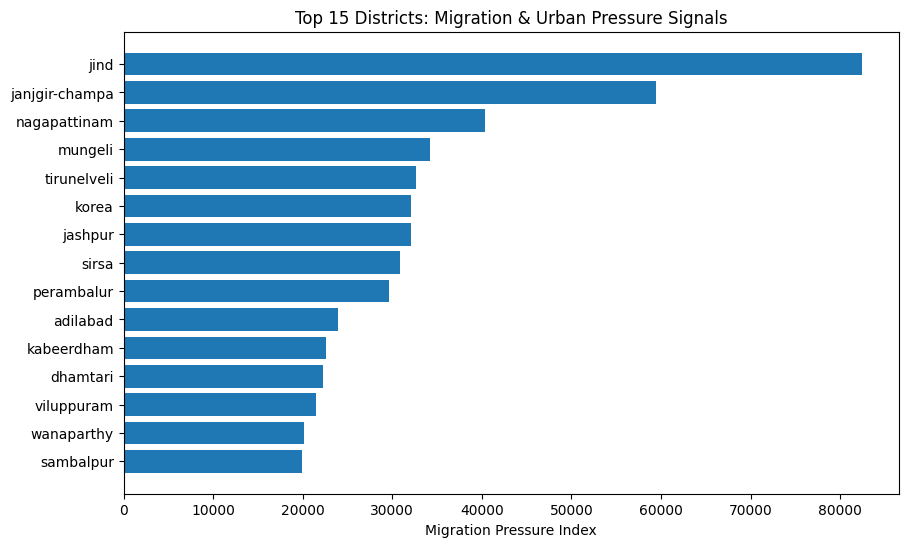

In [24]:
top = df.sort_values('migration_pressure_index', ascending=False).head(15)

plt.figure(figsize=(10,6))
plt.barh(top['district'], top['migration_pressure_index'])
plt.gca().invert_yaxis()
plt.title("Top 15 Districts: Migration & Urban Pressure Signals")
plt.xlabel("Migration Pressure Index")
plt.show()


## Insights: Migration & Urban Pressure Signals

The districts shown have very high demographic and biometric update activity, but comparatively low new enrollments.

This pattern strongly indicates in-migration, not natural population growth.

Jind and Janjgir-Champa stand out as the highest migration pressure districts, suggesting they are major workforce absorption zones.

Many districts in the list are semi-urban or industrial belts, not large metro cities, showing that migration pressure is spreading beyond metros.

High Aadhaar update activity in these districts suggests:

    -> Temporary or seasonal workforce movement

    -> Frequent address changes

    -> Dependence on local services without permanent settlement

These districts are likely experiencing urban service stress, especially on:

    -> Housing

    -> PDS and welfare portability

    -> Healthcare

    -> Local infrastructure

The signal reflects population churn, not failure of enrollment systems.

In [25]:
df.to_csv("..\\Data\\aadhar_insights_final.csv", index=False)